In [1]:
!pip install -q pytorch-lightning datasets==3.5.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:

isic_2024_challenge_path = kagglehub.competition_download('isic-2024-challenge')
kmader_skin_cancer_mnist_ham10000_path = kagglehub.dataset_download('kmader/skin-cancer-mnist-ham10000')

print('Data source import complete.')


100%|██████████| 2.00G/2.00G [01:35<00:00, 22.5MB/s]

Extracting files...


Data source import complete.


In [4]:
from google.colab import userdata
wandb_key = userdata.get('wandb_key')

In [5]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import wandb
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
from torchvision import models
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2
import h5py
from PIL import Image
import os
import time
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
from transformers import ViTModel, ViTImageProcessor
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import wandb
import pickle
import json
from pathlib import Path

## Original baseline

In [6]:
# Function to save test split indices
def save_test_split_indices(train_df, val_df, test_df, dataset_name, save_dir="/content/test_splits"):
    """Save train/val/test dataframe indices for reproducibility across experiments"""
    # Create directory if it doesn't exist
    Path(save_dir).mkdir(exist_ok=True, parents=True)

    # Create dictionary with indices for each split
    splits = {
        "train_indices": train_df.index.tolist(),
        "val_indices": val_df.index.tolist(),
        "test_indices": test_df.index.tolist()
    }

    # Save as pickle
    pickle_path = f"{save_dir}/{dataset_name}_split_indices.pkl"
    with open(pickle_path, 'wb') as f:
        pickle.dump(splits, f)

    # Also save as JSON for easier inspection/sharing
    json_path = f"{save_dir}/{dataset_name}_split_indices.json"
    with open(json_path, 'w') as f:
        json.dump(splits, f)

    print(f"Split indices for {dataset_name} saved to {pickle_path} and {json_path}")
    return pickle_path, json_path

# Function to load saved split indices
def load_split_indices(dataset_name, save_dir="/content/test_splits"):
    """Load previously saved split indices"""
    pickle_path = f"{save_dir}/{dataset_name}_split_indices.pkl"
    json_path = f"{save_dir}/{dataset_name}_split_indices.json"

    # Try to load pickle first
    if Path(pickle_path).exists():
        with open(pickle_path, 'rb') as f:
            splits = pickle.load(f)
        print(f"Loaded split indices from {pickle_path}")
        return splits
    # Fall back to JSON
    elif Path(json_path).exists():
        with open(json_path, 'r') as f:
            splits = json.load(f)
        print(f"Loaded split indices from {json_path}")
        return splits
    else:
        raise FileNotFoundError(f"No saved split indices found for {dataset_name}")

# Dataset classes
class ISICDataset(Dataset):
    def __init__(self, df, hdf5_file, processor, model_type="vit", neg_sample=None, pos_sample=None, seed=42):
        self.hdf5_file = hdf5_file
        self.processor = processor
        self.model_type = model_type
        self.seed = seed

        # Apply balanced sampling only for training
        if neg_sample is not None and pos_sample is not None:
            self.df = self._balance_sampling(df, neg_sample, pos_sample)
        else:
            self.df = df.reset_index(drop=True)

    def _balance_sampling(self, df, neg_sample, pos_sample):
        positive_df = df.query("target == 0").sample(frac=neg_sample, random_state=self.seed)
        negative_df = df.query("target == 1").sample(frac=pos_sample, replace=True, random_state=self.seed)
        balanced_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=self.seed)
        return balanced_df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        isic_id = self.df.iloc[idx]['isic_id']
        label = torch.tensor(self.df.iloc[idx]['target'], dtype=torch.float32)

        image_data = self.hdf5_file[isic_id][()]
        image_array = np.frombuffer(image_data, np.uint8)
        image = cv2.cvtColor(cv2.imdecode(image_array, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

        if self.model_type == "vit":
            # For ViT, use the processor directly
            inputs = self.processor(images=image, return_tensors="pt")
            image = inputs['pixel_values'].squeeze()
        else:
            # For EfficientNet, convert numpy array to PIL image and apply transforms
            image = self.processor(Image.fromarray(image))

        return image, label

class HAM10000Dataset(Dataset):
    def __init__(self, df, processor, model_type="vit", seed=42):
        self.processor = processor
        self.model_type = model_type
        self.seed = seed
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['image_path']
        label = torch.tensor(row['target'], dtype=torch.float32)

        # Load and process the image
        try:
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Could not load image at {image_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Provide a blank image as fallback
            image = np.zeros((224, 224, 3), dtype=np.uint8)

        if self.model_type == "vit":
            # Process for ViT model
            inputs = self.processor(images=image, return_tensors="pt")
            image = inputs['pixel_values'].squeeze()
        else:
            # Process for EfficientNet model
            image = self.processor(Image.fromarray(image))

        return image, label

# Lightning Module
class SkinLesionClassifier(pl.LightningModule):
    def __init__(self, model_name="vit", learning_rate=1e-4, pos_weight=1.0):
        super().__init__()
        self.save_hyperparameters()
        self.model_name = model_name
        self.learning_rate = learning_rate

        # Model initialization
        if model_name == "vit":
            self.model = ViTModel.from_pretrained('google/vit-base-patch16-224')
            self.classifier = nn.Linear(self.model.config.hidden_size, 1)
        elif model_name == "effnet_b0":
            self.model = models.efficientnet_b0(pretrained=True)
            self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 1)
            self.classifier = self.model.classifier[1]
        elif model_name == "effnet_b4":
            self.model = models.efficientnet_b4(pretrained=True)
            self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 1)
            self.classifier = self.model.classifier[1]
        else:
            raise ValueError("Model name must be 'vit', 'effnet_b0', or 'effnet_b4'")

        self.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))

        # For validation metrics tracking
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, x):
        if self.model_name == "vit":
            outputs = self.model(pixel_values=x)
            x = outputs.last_hidden_state[:, 0, :]  # CLS token
            x = self.classifier(x)
        else:
            x = self.model(x)
        return x.squeeze()

    def training_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels)

        # Calculate metrics (consistent with validation)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        acc = (preds == labels).float().mean()
        f1 = self._calculate_f1(labels, preds)

        # Log metrics
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        self.log('train_f1', f1, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels)

        # Apply sigmoid for predictions
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        # Calculate metrics
        acc = (preds == labels).float().mean()
        f1 = self._calculate_f1(labels, preds)

        # Log metrics
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        self.log('val_f1', f1, prog_bar=True)

        # Store probabilities, not logits, for AUC calculation
        self.validation_step_outputs.append({
            'probs': probs,  # Store probabilities for AUC
            'preds': preds,  # Store binary predictions for other metrics
            'labels': labels,
            'logits': logits  # Store logits for debugging
        })

        return loss

    def on_validation_epoch_end(self):
        # Collect all outputs
        all_probs = torch.cat([x['probs'] for x in self.validation_step_outputs])
        all_preds = torch.cat([x['preds'] for x in self.validation_step_outputs])
        all_labels = torch.cat([x['labels'] for x in self.validation_step_outputs])

        # Print validation set statistics
        pos_count = all_labels.sum().item()
        total = len(all_labels)
        pos_ratio = pos_count / total
        print(f"Validation set: {pos_count}/{total} positive samples ({pos_ratio:.2%})")

        # Print prediction statistics
        pred_pos = all_preds.sum().item()
        pred_ratio = pred_pos / total
        print(f"Predictions: {pred_pos}/{total} predicted positive ({pred_ratio:.2%})")

        # Print confusion matrix
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(all_labels.cpu().numpy(), all_preds.cpu().numpy())
        print(f"Confusion Matrix:\n{cm}")

        # Calculate AUC using probabilities
        try:
            auc = roc_auc_score(all_labels.cpu().numpy(), all_probs.cpu().numpy())
            self.log('val_auc', auc, prog_bar=True)
        except Exception as e:
            print(f"Error calculating AUC: {e}")

        # Try to find optimal threshold
        try:
            from sklearn.metrics import f1_score
            thresholds = np.arange(0.1, 0.9, 0.05)
            best_f1 = 0
            best_thresh = 0.5

            for thresh in thresholds:
                thresh_preds = (all_probs.cpu().numpy() > thresh).astype(float)
                f1 = f1_score(all_labels.cpu().numpy(), thresh_preds)
                if f1 > best_f1:
                    best_f1 = f1
                    best_thresh = thresh

            print(f"Best threshold: {best_thresh:.2f}, F1: {best_f1:.4f}")

            # Log optimal threshold stats
            self.log('val_f1_optimal', best_f1, prog_bar=True)
            self.log('val_optimal_threshold', best_thresh, prog_bar=False)

            # Recalculate metrics with optimal threshold
            optimal_preds = (all_probs.cpu().numpy() > best_thresh).astype(float)
            cm_optimal = confusion_matrix(all_labels.cpu().numpy(), optimal_preds)
            print(f"Confusion Matrix with optimal threshold:\n{cm_optimal}")

            from sklearn.metrics import precision_score, recall_score
            precision = precision_score(all_labels.cpu().numpy(), optimal_preds)
            recall = recall_score(all_labels.cpu().numpy(), optimal_preds)
            print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {best_f1:.4f}")

        except Exception as e:
            print(f"Error finding optimal threshold: {e}")

        # Clear outputs
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels)

        # Calculate metrics (consistent with validation)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        acc = (preds == labels).float().mean()
        f1 = self._calculate_f1(labels, preds)

        # Log metrics
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        self.log('test_f1', f1)

        # Store for epoch end calculations
        self.test_step_outputs.append({
            'probs': probs,
            'preds': preds,
            'labels': labels
        })

        return loss

    def on_test_epoch_end(self):
        # Collect all outputs
        all_probs = torch.cat([x['probs'] for x in self.test_step_outputs])
        all_preds = torch.cat([x['preds'] for x in self.test_step_outputs])
        all_labels = torch.cat([x['labels'] for x in self.test_step_outputs])

        # Print test set statistics
        pos_count = all_labels.sum().item()
        total = len(all_labels)
        print(f"Test set: {pos_count}/{total} positive samples ({pos_count/total:.2%})")

        # Print prediction statistics
        pred_pos = all_preds.sum().item()
        print(f"Predictions: {pred_pos}/{total} predicted positive ({pred_pos/total:.2%})")

        # Print confusion matrix
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(all_labels.cpu().numpy(), all_preds.cpu().numpy())
        print(f"Confusion Matrix:\n{cm}")

        # Calculate AUC
        try:
            auc = roc_auc_score(all_labels.cpu().numpy(), all_probs.cpu().numpy())
            self.log('test_auc', auc)
        except:
            pass

        # Clear outputs
        self.test_step_outputs.clear()

    def _calculate_f1(self, y_true, y_pred):
        tp = (y_true * y_pred).sum().float()
        fp = ((1 - y_true) * y_pred).sum().float()
        fn = (y_true * (1 - y_pred)).sum().float()

        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)

        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
        return f1

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "frequency": 1
            },
        }

# Data preparation functions
def prepare_isic_data(train_hdf5_path, train_metadata_path, use_saved_splits=True):
    """Prepare ISIC dataset with option to use saved splits"""
    # Load metadata
    train_hdf5 = h5py.File(train_hdf5_path, 'r')
    train_metadata = pd.read_csv(train_metadata_path)

    # Try to load saved splits if requested
    if use_saved_splits:
        try:
            splits = load_split_indices("isic")
            # Convert indices to integer if they're strings (can happen with JSON)
            train_indices = [int(idx) for idx in splits["train_indices"]]
            val_indices = [int(idx) for idx in splits["val_indices"]]
            test_indices = [int(idx) for idx in splits["test_indices"]]

            # Use .iloc for positional indexing instead of .loc
            train_df = train_metadata.iloc[train_indices].reset_index(drop=True)
            val_df = train_metadata.iloc[val_indices].reset_index(drop=True)
            test_df = train_metadata.iloc[test_indices].reset_index(drop=True)
            print("Using saved ISIC dataset splits")
            return train_df, val_df, test_df, train_hdf5
        except FileNotFoundError:
            print("No saved splits found, creating new splits")

    # Create new splits
    # First split into train+val and test
    train_val_df, test_df = train_test_split(train_metadata, test_size=0.15, random_state=42)
    # Then split train+val into train and validation
    train_df, val_df = train_test_split(train_val_df, test_size=0.15, random_state=42)

    # Save the splits
    save_test_split_indices(train_df, val_df, test_df, "isic")

    print(f"ISIC Dataset: Training: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

    return train_df, val_df, test_df, train_hdf5

def prepare_ham10000_data(ham_metadata_path, img_dir1, img_dir2, use_saved_splits=True):
    """Prepare HAM10000 dataset with option to use saved splits"""
    # Load metadata
    df = pd.read_csv(ham_metadata_path)

    # Dictionary to map lesion types to benign or malignant
    benign_types = ['nv', 'bkl', 'akiec', 'vasc', 'df']
    malignant_types = ['mel', 'bcc']

    # Add binary target column: 0 for benign, 1 for malignant
    df['target'] = df['dx'].apply(lambda x: 0 if x in benign_types else 1)

    # Function to locate the image path
    def get_image_path(image_id):
        filename = f"{image_id}.jpg"
        if os.path.exists(os.path.join(img_dir1, filename)):
            return os.path.join(img_dir1, filename)
        elif os.path.exists(os.path.join(img_dir2, filename)):
            return os.path.join(img_dir2, filename)
        else:
            return None  # In case the image is missing

    df['image_path'] = df['image_id'].apply(get_image_path)

    # Remove any rows with missing images
    df = df[df['image_path'].notna()].reset_index(drop=True)

    # Try to load saved splits if requested
    if use_saved_splits:
        try:
            splits = load_split_indices("ham10000")
            # Convert indices to integer if they're strings (can happen with JSON)
            train_indices = [int(idx) for idx in splits["train_indices"]]
            val_indices = [int(idx) for idx in splits["val_indices"]]
            test_indices = [int(idx) for idx in splits["test_indices"]]

            # Use .iloc for positional indexing
            train_df = df.iloc[train_indices].reset_index(drop=True)
            val_df = df.iloc[val_indices].reset_index(drop=True)
            test_df = df.iloc[test_indices].reset_index(drop=True)
            print("Using saved HAM10000 dataset splits")
            return train_df, val_df, test_df
        except FileNotFoundError:
            print("No saved splits found, creating new splits")

    # Create new splits
    # First split into train+val and test
    train_val_df, test_df = train_test_split(df, test_size=0.15, random_state=42)
    # Then split train+val into train and validation
    train_df, val_df = train_test_split(train_val_df, test_size=0.15, random_state=42)

    # Save the splits
    save_test_split_indices(train_df, val_df, test_df, "ham10000")

    print(f"HAM10000 Dataset: Training: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

    return train_df, val_df, test_df

# Data module
class SkinLesionDataModule(pl.LightningDataModule):
    def __init__(self, dataset_name, model_name, batch_size=16, num_workers=4, use_saved_splits=True):
        super().__init__()
        self.dataset_name = dataset_name
        self.model_name = model_name
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.use_saved_splits = use_saved_splits

        # Set up preprocessing based on model type
        if model_name == "vit":
            self.processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
        else:
            target_size = 224 if model_name == "effnet_b0" else 380
            self.processor = transforms.Compose([
                transforms.Resize(target_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        # Paths for ISIC dataset
        self.train_hdf5_path =  isic_2024_challenge_path + '/train-image.hdf5'
        self.train_metadata_path = isic_2024_challenge_path + '/train-metadata.csv'

        # Paths for HAM10000 dataset
        self.ham_metadata_path = kmader_skin_cancer_mnist_ham10000_path + '/HAM10000_metadata.csv'
        self.img_dir1 = kmader_skin_cancer_mnist_ham10000_path + "/HAM10000_images_part_1"
        self.img_dir2 = kmader_skin_cancer_mnist_ham10000_path + "/HAM10000_images_part_2"

    def setup(self, stage=None):
        if self.dataset_name == "isic":
            self.train_df, self.val_df, self.test_df, self.train_hdf5 = prepare_isic_data(
                self.train_hdf5_path, self.train_metadata_path,
                use_saved_splits=self.use_saved_splits
            )

            # Create datasets
            self.train_dataset = ISICDataset(
                self.train_df, self.train_hdf5, self.processor,
                model_type=self.model_name, neg_sample=0.01, pos_sample=5.0
            )
            self.val_dataset = ISICDataset(
                self.val_df, self.train_hdf5, self.processor,
                model_type=self.model_name
            )
            self.test_dataset = ISICDataset(
                self.test_df, self.train_hdf5, self.processor,
                model_type=self.model_name
            )

        elif self.dataset_name == "ham10000":
            self.train_df, self.val_df, self.test_df = prepare_ham10000_data(
                self.ham_metadata_path, self.img_dir1, self.img_dir2,
                use_saved_splits=self.use_saved_splits
            )

            # Create datasets
            self.train_dataset = HAM10000Dataset(
                self.train_df, self.processor, model_type=self.model_name
            )
            self.val_dataset = HAM10000Dataset(
                self.val_df, self.processor, model_type=self.model_name
            )
            self.test_dataset = HAM10000Dataset(
                self.test_df, self.processor, model_type=self.model_name
            )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size,
            shuffle=True, num_workers=self.num_workers, pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, batch_size=self.batch_size,
            shuffle=False, num_workers=self.num_workers, pin_memory=True
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, batch_size=self.batch_size,
            shuffle=False, num_workers=self.num_workers, pin_memory=True
        )

## Experiments with additional data

### Classes

In [7]:

# Import your existing classes
# from isic_and_ham import SkinLesionClassifier, SkinLesionDataModule
# Global cache for datasets
_dataset_cache = {}

class GeneratedSkinLesionDataset(Dataset):
    def __init__(self, processor, model_type="vit", dataset_type="dev", max_samples=None, seed=42):
        """
        Args:
            processor: Image processor/transforms
            model_type: Model architecture type ('vit' or 'effnet')
            dataset_type: Which generated dataset ('dev', 'schnell', or 'combined')
            max_samples: Maximum number of samples to use (for partial dataset)
            seed: Random seed for reproducibility
        """
        from datasets import load_dataset

        self.processor = processor
        self.model_type = model_type
        self.seed = seed

        # HF dataset repos
        dev_repo = "Shah1st/skin-cancer-flux.1-dev-images"
        schnell_repo = "Shah1st/skin-cancer-flux.1-schnell-images"

        # Check if dataset is already in cache
        cache_key = f"{dataset_type}_{max_samples}_{seed}"
        if cache_key in _dataset_cache:
            print(f"Using cached {dataset_type} dataset")
            self.files_with_labels = _dataset_cache[cache_key]
        else:
            print(f"Loading {dataset_type} dataset from Hugging Face")

            # Load datasets from Hugging Face
            if dataset_type == "combined":
                # Load both dev and schnell datasets
                print(f"Loading datasets from HF: {dev_repo} and {schnell_repo}")
                dev_dataset = load_dataset(dev_repo, split="train")
                schnell_dataset = load_dataset(schnell_repo, split="train")

                # Combine datasets
                self.files_with_labels = []

                # Process dev dataset
                for item in dev_dataset:
                    filename = item['file_name']
                    image = item['image']

                    # Parse label from filename
                    if 'benign' in filename.lower():
                        label = 0  # Benign
                    elif 'malignant' in filename.lower():
                        label = 1  # Malignant
                    else:
                        print(f"Skipping file with unknown label: {filename}")
                        continue

                    self.files_with_labels.append((image, label))

                # Process schnell dataset
                for item in schnell_dataset:
                    filename = item['file_name']
                    image = item['image']

                    # Parse label from filename
                    if 'benign' in filename.lower():
                        label = 0  # Benign
                    elif 'malignant' in filename.lower():
                        label = 1  # Malignant
                    else:
                        print(f"Skipping file with unknown label: {filename}")
                        continue

                    self.files_with_labels.append((image, label))
            else:
                # Load single dataset
                repo = dev_repo if dataset_type == "dev" else schnell_repo
                print(f"Loading dataset from HF: {repo}")
                dataset = load_dataset(repo, split="train")

                # Process dataset
                self.files_with_labels = []
                for item in dataset:
                    filename = item['file_name']
                    image = item['image']

                    # Parse label from filename
                    if 'benign' in filename.lower():
                        label = 0  # Benign
                    elif 'malignant' in filename.lower():
                        label = 1  # Malignant
                    else:
                        print(f"Skipping file with unknown label: {filename}")
                        continue

                    self.files_with_labels.append((image, label))

            # Shuffle and limit samples if needed
            np.random.seed(seed)
            np.random.shuffle(self.files_with_labels)

            if max_samples is not None:
                self.files_with_labels = self.files_with_labels[:max_samples]

            # Store in cache
            _dataset_cache[cache_key] = self.files_with_labels

        print(f"Dataset has {len(self.files_with_labels)} images")

        # Print class distribution
        benign_count = sum(1 for _, label in self.files_with_labels if label == 0)
        malignant_count = sum(1 for _, label in self.files_with_labels if label == 1)
        print(f"Class distribution: Benign={benign_count}, Malignant={malignant_count}")

    def __len__(self):
        return len(self.files_with_labels)

    def __getitem__(self, idx):
        image, label = self.files_with_labels[idx]
        label = torch.tensor(label, dtype=torch.float32)

        # Image is already a PIL image from the HF dataset

        # Process image based on model type
        if self.model_type == "vit":
            # For ViT, use the processor directly
            inputs = self.processor(images=image, return_tensors="pt")
            image = inputs['pixel_values'].squeeze()
        else:
            # For EfficientNet, use the transforms
            image = self.processor(image)

        return image, label

# Extended DataModule for experiments
class ExperimentalSkinLesionDataModule(pl.LightningDataModule):
    def __init__(
        self,
        dataset_name,
        model_name,
        batch_size=32,
        num_workers=1,
        use_saved_splits=True,
        use_real_data=True,
        use_generated_data=False,
        generated_data_ratio=1.0,  # How many generated images to add relative to real dataset
        generated_data_type="dev",  # "dev", "schnell", or "combined"
    ):
        super().__init__()
        self.dataset_name = dataset_name
        self.model_name = model_name
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.use_saved_splits = use_saved_splits

        # Experiment settings
        self.use_real_data = use_real_data
        self.use_generated_data = use_generated_data
        self.generated_data_ratio = generated_data_ratio
        self.generated_data_type = generated_data_type

        # Set up preprocessing based on model type
        if model_name == "vit":
            from transformers import ViTImageProcessor
            self.processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
        else:
            target_size = 224 if model_name == "effnet_b0" else 380
            self.processor = transforms.Compose([
                transforms.Resize(target_size),
                transforms.CenterCrop(target_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        # Make sure paths match your Colab environment
        # Paths for ISIC dataset (from original code)
        # Paths for ISIC dataset (from original code)
        self.train_hdf5_path = isic_2024_challenge_path + '/train-image.hdf5'
        self.train_metadata_path = isic_2024_challenge_path + '/train-metadata.csv'

        # Paths for HAM10000 dataset (from original code)
        self.ham_metadata_path = kmader_skin_cancer_mnist_ham10000_path + '/HAM10000_metadata.csv'
        self.img_dir1 = kmader_skin_cancer_mnist_ham10000_path + "/HAM10000_images_part_1"
        self.img_dir2 = kmader_skin_cancer_mnist_ham10000_path + "/HAM10000_images_part_2"

    def setup(self, stage=None):
        # Setup original datasets from the provided code
        if self.dataset_name == "isic":
            #from isic_and_ham import prepare_isic_data, ISICDataset

            self.train_df, self.val_df, self.test_df, self.train_hdf5 = prepare_isic_data(
                self.train_hdf5_path, self.train_metadata_path,
                use_saved_splits=self.use_saved_splits
            )

            # Create datasets
            if self.use_real_data:
                self.real_train_dataset = ISICDataset(
                    self.train_df, self.train_hdf5, self.processor,
                    model_type=self.model_name, neg_sample=0.01, pos_sample=5.0
                )
            else:
                self.real_train_dataset = None

            self.val_dataset = ISICDataset(
                self.val_df, self.train_hdf5, self.processor,
                model_type=self.model_name
            )
            self.test_dataset = ISICDataset(
                self.test_df, self.train_hdf5, self.processor,
                model_type=self.model_name
            )

        elif self.dataset_name == "ham10000":
            #from isic_and_ham import prepare_ham10000_data, HAM10000Dataset

            self.train_df, self.val_df, self.test_df = prepare_ham10000_data(
                self.ham_metadata_path, self.img_dir1, self.img_dir2,
                use_saved_splits=self.use_saved_splits
            )

            # Create datasets
            if self.use_real_data:
                self.real_train_dataset = HAM10000Dataset(
                    self.train_df, self.processor, model_type=self.model_name
                )
            else:
                self.real_train_dataset = None

            self.val_dataset = HAM10000Dataset(
                self.val_df, self.processor, model_type=self.model_name
            )
            self.test_dataset = HAM10000Dataset(
                self.test_df, self.processor, model_type=self.model_name
            )

        # Add generated dataset if specified
        if self.use_generated_data:
            # Calculate how many generated samples to use
            if self.real_train_dataset is not None:
                real_size = len(self.real_train_dataset)
                gen_samples = int(real_size * self.generated_data_ratio)
            else:
                # If no real data, use a fixed number of generated samples
                gen_samples = 5000 if self.generated_data_ratio <= 1.0 else 10000

            self.gen_train_dataset = GeneratedSkinLesionDataset(
                self.processor,
                model_type=self.model_name,
                dataset_type=self.generated_data_type,
                max_samples=gen_samples
            )
        else:
            self.gen_train_dataset = None

        # Create combined training dataset
        if self.real_train_dataset is not None and self.gen_train_dataset is not None:
            self.train_dataset = ConcatDataset([self.real_train_dataset, self.gen_train_dataset])
        elif self.real_train_dataset is not None:
            self.train_dataset = self.real_train_dataset
        elif self.gen_train_dataset is not None:
            self.train_dataset = self.gen_train_dataset
        else:
            raise ValueError("At least one of real or generated data must be enabled")

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size,
            shuffle=True, num_workers=self.num_workers, pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, batch_size=self.batch_size,
            shuffle=False, num_workers=self.num_workers, pin_memory=True
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, batch_size=self.batch_size,
            shuffle=False, num_workers=self.num_workers, pin_memory=True
        )

# Class for Experiment 3: Adversarial Discrimination
class RealVsGeneratedDataset(Dataset):
    def __init__(self, real_dataset, generated_dataset, processor, model_type="vit", real_sample_ratio=1.0, gen_sample_ratio=1.0, seed=42):
        """
        Dataset for discriminating between real and generated images

        Args:
            real_dataset: Dataset containing real images
            generated_dataset: Dataset containing generated images
            processor: Image processor/transforms
            model_type: Model architecture type
            real_sample_ratio: Fraction of real data to use (0.0-1.0)
            gen_sample_ratio: Fraction of generated data to use (0.0-1.0)
            seed: Random seed for reproducibility
        """
        self.processor = processor
        self.model_type = model_type
        self.seed = seed

        # Get samples from real dataset
        real_indices = np.random.RandomState(seed).permutation(len(real_dataset))
        real_sample_size = int(len(real_dataset) * real_sample_ratio)
        real_indices = real_indices[:real_sample_size]

        # Get samples from generated dataset
        gen_indices = np.random.RandomState(seed+1).permutation(len(generated_dataset))
        gen_sample_size = int(len(generated_dataset) * gen_sample_ratio)
        gen_indices = gen_indices[:gen_sample_size]

        # Create combined dataset with labels (0=real, 1=generated)
        self.samples = []

        # Add real samples (label 0)
        for idx in real_indices:
            image, original_label = real_dataset[idx]
            self.samples.append((image, 0, original_label))  # Store original label too

        # Add generated samples (label 1)
        for idx in gen_indices:
            image, original_label = generated_dataset[idx]
            self.samples.append((image, 1, original_label))  # Store original label too

        # Shuffle samples
        np.random.RandomState(seed+2).shuffle(self.samples)

        print(f"Created real vs generated dataset with {len(self.samples)} samples")
        print(f"Real samples: {real_sample_size}, Generated samples: {gen_sample_size}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image, is_generated, original_label = self.samples[idx]
        label = torch.tensor(is_generated, dtype=torch.float32)
        return image, label

### Experimental setup

#### Exp1

In [8]:
# Function to run Experiment 1: Impact of augmenting with generated data
def run_experiment_1(dataset_name, model_name, wandb_project, wandb_api_key=None):
    """
    Run experiment to test the impact of adding generated data to real data
    """
    # Configurations to test
    experiment_configs = [
        {"name": "baseline", "real_data": True, "gen_data": False},           # Only real data
        {"name": "gen50", "real_data": True, "gen_data": True, "ratio": 0.5}, # Real + 50% generated
        {"name": "gen100", "real_data": True, "gen_data": True, "ratio": 1.0},  # Real + 100% generated
        {"name": "gen200", "real_data": True, "gen_data": True, "ratio": 2.0}, # Real + 200% generated
    ]

    results = []

    for config in experiment_configs:
        print(f"\n{'='*50}")
        print(f"Running Experiment 1 - Config: {config['name']}")
        print(f"{'='*50}\n")

        # Create data module
        dm = ExperimentalSkinLesionDataModule(
            dataset_name=dataset_name,
            model_name=model_name,
            batch_size=64,
            use_real_data=config['real_data'],
            use_generated_data=config.get('gen_data', False),
            generated_data_ratio=config.get('ratio', 0.0),
            generated_data_type="combined"  # Use both dev and schnell
        )

        # Initialize wandb if API key is provided
        if wandb_api_key:
            wandb.login(key=wandb_api_key)
            logger = WandbLogger(
                project=wandb_project,
                name=f"{dataset_name}_{model_name}_{config['name']}",
                log_model=True
            )
        else:
            from pytorch_lightning.loggers import TensorBoardLogger
            logger = TensorBoardLogger(
                "/content/logs",
                name=f"{dataset_name}_{model_name}_{config['name']}"
            )

        # Initialize model
        model = SkinLesionClassifier(model_name=model_name)

        # Setup callbacks
        checkpoint_callback = ModelCheckpoint(
            dirpath=f"/content/models/{dataset_name}_{model_name}_{config['name']}",
            filename="{epoch}-{val_loss:.2f}-{val_acc:.2f}",
            save_top_k=1,
            verbose=True,
            monitor='val_loss',
            mode='min'
        )

        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            verbose=True,
            mode='min'
        )

        # Initialize trainer
        trainer = pl.Trainer(
            max_epochs=5,
            accelerator='gpu',
            devices=1,
            callbacks=[checkpoint_callback, early_stopping],
            logger=logger,
            log_every_n_steps=50,
            deterministic=True
        )

        # Train model
        trainer.fit(model, dm)

        # Test model
        test_results = trainer.test(model, datamodule=dm)

        # Save results
        config_results = {
            "config": config['name'],
            "dataset": dataset_name,
            "model": model_name,
            "test_loss": test_results[0]['test_loss'],
            "test_acc": test_results[0]['test_acc'],
            "test_f1": test_results[0]['test_f1'],
            "test_auc": test_results[0].get('test_auc', None),
            "best_model_path": checkpoint_callback.best_model_path
        }

        results.append(config_results)

        # If using wandb, finish run
        if wandb_api_key:
            wandb.finish()

    # Save and analyze results
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"/content/drive/MyDrive/Datasets/experiment1_{dataset_name}_{model_name}_results.csv", index=False)

    # Create comparison plots
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    sns.barplot(x='config', y='test_acc', data=results_df)
    plt.title(f'Test Accuracy - {dataset_name} - {model_name}')
    plt.ylim(0.5, 1.0)

    plt.subplot(2, 2, 2)
    sns.barplot(x='config', y='test_f1', data=results_df)
    plt.title(f'Test F1 Score - {dataset_name} - {model_name}')
    plt.ylim(0.5, 1.0)

    if all(result['test_auc'] is not None for result in results):
        plt.subplot(2, 2, 3)
        sns.barplot(x='config', y='test_auc', data=results_df)
        plt.title(f'Test AUC - {dataset_name} - {model_name}')
        plt.ylim(0.5, 1.0)

    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/Datasets/experiment1_{dataset_name}_{model_name}_results.png")

    return results_df


#### Exp2

In [9]:

# Function to run Experiment 2: Training on generated data only
def run_experiment_2(dataset_name, model_name, wandb_project, wandb_api_key=None):
    """
    Run experiment to test training on generated data only
    """
    # Configurations to test
    experiment_configs = [
        #{"name": "real_only", "real_data": True, "gen_data": False},                    # Baseline
        #{"name": "gen_only_dev", "real_data": False, "gen_data": True, "type": "dev"},  # Only FLUX.1-dev
        #{"name": "gen_only_schnell", "real_data": False, "gen_data": True, "type": "schnell"}, # Only FLUX.1-schnell
        {"name": "gen_only_combined", "real_data": False, "gen_data": True, "type": "combined"}, # Both generated sets
    ]

    results = []

    for config in experiment_configs:
        print(f"\n{'='*50}")
        print(f"Running Experiment 2 - Config: {config['name']}")
        print(f"{'='*50}\n")

        # Skip real_only if we already ran it in experiment 1
        if config['name'] == "real_only" and os.path.exists(f"/content/drive/MyDrive/Datasets/experiment1_{dataset_name}_{model_name}_results.csv"):
            try:
                exp1_results = pd.read_csv(f"/content/drive/MyDrive/Datasets/experiment1_{dataset_name}_{model_name}_results.csv")
                baseline_row = exp1_results[exp1_results['config'] == 'baseline']
                if len(baseline_row) > 0:
                    print("Using baseline results from Experiment 1")
                    results.append({
                        "config": config['name'],
                        "dataset": dataset_name,
                        "model": model_name,
                        "test_loss": baseline_row['test_loss'].values[0],
                        "test_acc": baseline_row['test_acc'].values[0],
                        "test_f1": baseline_row['test_f1'].values[0],
                        "test_auc": baseline_row['test_auc'].values[0],
                        "best_model_path": baseline_row['best_model_path'].values[0]
                    })
                    continue
            except Exception as e:
                print(f"Could not load baseline results from Experiment 1: {e}")

        # Create data module
        dm = ExperimentalSkinLesionDataModule(
            dataset_name=dataset_name,
            model_name=model_name,
            batch_size=64,
            use_real_data=config['real_data'],
            use_generated_data=config.get('gen_data', False),
            generated_data_ratio=2.0,  # Use more generated data when training only on generated
            generated_data_type=config.get('type', "combined")
        )

        # Initialize wandb if API key is provided
        if wandb_api_key:
            wandb.login(key=wandb_api_key)
            logger = WandbLogger(
                project=wandb_project,
                name=f"{dataset_name}_{model_name}_{config['name']}",
                log_model=True
            )
        else:
            from pytorch_lightning.loggers import TensorBoardLogger
            logger = TensorBoardLogger(
                "/content/logs",
                name=f"{dataset_name}_{model_name}_{config['name']}"
            )

        # Initialize model
        model = SkinLesionClassifier(model_name=model_name)

        # Setup callbacks
        checkpoint_callback = ModelCheckpoint(
            dirpath=f"/content/models/{dataset_name}_{model_name}_{config['name']}",
            filename="{epoch}-{val_loss:.2f}-{val_acc:.2f}",
            save_top_k=1,
            verbose=True,
            monitor='val_loss',
            mode='min'
        )

        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            verbose=True,
            mode='min'
        )

        # Initialize trainer
        trainer = pl.Trainer(
            max_epochs=5,
            accelerator='gpu',
            devices=1,
            callbacks=[checkpoint_callback, early_stopping],
            logger=logger,
            log_every_n_steps=50,
            deterministic=True
        )

        # Train model
        trainer.fit(model, dm)

        # Test model
        test_results = trainer.test(model, datamodule=dm)

        # Save results
        config_results = {
            "config": config['name'],
            "dataset": dataset_name,
            "model": model_name,
            "test_loss": test_results[0]['test_loss'],
            "test_acc": test_results[0]['test_acc'],
            "test_f1": test_results[0]['test_f1'],
            "test_auc": test_results[0].get('test_auc', None),
            "best_model_path": checkpoint_callback.best_model_path
        }

        results.append(config_results)

        # If using wandb, finish run
        if wandb_api_key:
            wandb.finish()

    # Save and analyze results
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"/content/drive/MyDrive/Datasets/experiment2_{dataset_name}_{model_name}_results.csv", index=False)

    # Create comparison plots
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    sns.barplot(x='config', y='test_acc', data=results_df)
    plt.title(f'Test Accuracy - {dataset_name} - {model_name}')
    plt.ylim(0.5, 1.0)

    plt.subplot(2, 2, 2)
    sns.barplot(x='config', y='test_f1', data=results_df)
    plt.title(f'Test F1 Score - {dataset_name} - {model_name}')
    plt.ylim(0.5, 1.0)

    if all(result['test_auc'] is not None for result in results):
        plt.subplot(2, 2, 3)
        sns.barplot(x='config', y='test_auc', data=results_df)
        plt.title(f'Test AUC - {dataset_name} - {model_name}')
        plt.ylim(0.5, 1.0)

    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/Datasets/experiment2_{dataset_name}_{model_name}_results.png")

    return results_df

#### Exp3

In [10]:
# Function to run Experiment 3: Adversarial discrimination
def run_experiment_3(dataset_name, model_name, wandb_project, wandb_api_key=None):
    """
    Run experiment to test if a model can distinguish between real and generated images
    """
    print(f"\n{'='*50}")
    print(f"Running Experiment 3 - Real vs Generated Classification")
    print(f"{'='*50}\n")

    # Set up processing
    if model_name == "vit":
        from transformers import ViTImageProcessor
        processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
    else:
        target_size = 224 if model_name == "effnet_b0" else 380
        processor = transforms.Compose([
            transforms.Resize(target_size),
            transforms.CenterCrop(target_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    # First, set up regular data modules to get the datasets
    real_dm = ExperimentalSkinLesionDataModule(
        dataset_name=dataset_name,
        model_name=model_name,
        use_real_data=True,
        use_generated_data=False
    )
    real_dm.setup()

    gen_dm = ExperimentalSkinLesionDataModule(
        dataset_name=dataset_name,
        model_name=model_name,
        use_real_data=False,
        use_generated_data=True,
        generated_data_type="combined"
    )
    gen_dm.setup()

    # Create dataset for distinguishing real vs generated
    adv_train_dataset = RealVsGeneratedDataset(
        real_dataset=real_dm.train_dataset,
        generated_dataset=gen_dm.train_dataset,
        processor=processor,
        model_type=model_name,
        real_sample_ratio=0.7,  # Use 70% of real data
        gen_sample_ratio=0.7    # Use 70% of generated data
    )

    adv_val_dataset = RealVsGeneratedDataset(
        real_dataset=real_dm.val_dataset,
        generated_dataset=gen_dm.train_dataset,  # Use part of training generated data for validation
        processor=processor,
        model_type=model_name,
        real_sample_ratio=0.5,
        gen_sample_ratio=0.15,
        seed=43  # Different seed for validation split
    )

    # Create dataloaders
    adv_train_loader = DataLoader(
        adv_train_dataset, batch_size=32,
        shuffle=True, num_workers=4, pin_memory=True
    )

    adv_val_loader = DataLoader(
        adv_val_dataset, batch_size=32,
        shuffle=False, num_workers=4, pin_memory=True
    )

    # Initialize model for adversarial detection
    adv_model = SkinLesionClassifier(model_name=model_name)

    # Initialize wandb if API key is provided
    if wandb_api_key:
        wandb.login(key=wandb_api_key)
        logger = WandbLogger(
            project=wandb_project,
            name=f"{dataset_name}_{model_name}_adversarial",
            log_model="all"
        )
    else:
        from pytorch_lightning.loggers import TensorBoardLogger
        logger = TensorBoardLogger(
            "/content/logs",
            name=f"{dataset_name}_{model_name}_adversarial"
        )

    # Setup callbacks
    checkpoint_callback = ModelCheckpoint(
        dirpath=f"/content/models/{dataset_name}_{model_name}_adversarial",
        filename="{epoch}-{val_loss:.2f}-{val_acc:.2f}",
        save_top_k=1,
        verbose=True,
        monitor='val_loss',
        mode='min'
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=True,
        mode='min'
    )

    # Initialize trainer
    trainer = pl.Trainer(
        max_epochs=10,
        accelerator='gpu',
        devices=1,
        callbacks=[checkpoint_callback, early_stopping],
        logger=logger,
        log_every_n_steps=50,
        deterministic=True
    )

    # Train model
    trainer.fit(adv_model, adv_train_loader, adv_val_loader)

    # Evaluate model
    # Create a test dataset with equal parts real and generated
    adv_test_dataset = RealVsGeneratedDataset(
        real_dataset=real_dm.test_dataset,
        generated_dataset=gen_dm.train_dataset,  # Use remaining generated data
        processor=processor,
        model_type=model_name,
        real_sample_ratio=1.0,  # Use all test data
        gen_sample_ratio=0.15,  # Match approximately to test set size
        seed=44  # Different seed for test split
    )

    adv_test_loader = DataLoader(
        adv_test_dataset, batch_size=16,
        shuffle=False, num_workers=4, pin_memory=True
    )

    # Evaluate
    test_results = trainer.test(adv_model, adv_test_loader)

    # Process results
    print("Adversarial Detection Results:")
    print(f"Accuracy: {test_results[0]['test_acc']}")
    print(f"F1 Score: {test_results[0]['test_f1']}")
    if 'test_auc' in test_results[0]:
        print(f"AUC: {test_results[0]['test_auc']}")

    # Save results
    results = {
        "dataset": dataset_name,
        "model": model_name,
        "test_loss": test_results[0]['test_loss'],
        "test_acc": test_results[0]['test_acc'],
        "test_f1": test_results[0]['test_f1'],
        "test_auc": test_results[0].get('test_auc', None),
        "best_model_path": checkpoint_callback.best_model_path
    }

    # Save as dataframe
    results_df = pd.DataFrame([results])
    results_df.to_csv(f"/content/drive/MyDrive/Datasets/experiment3_{dataset_name}_{model_name}_results.csv", index=False)

    # If using wandb, finish run
    if wandb_api_key:
        wandb.finish()

    return results



### Together

In [11]:
# Function to run all experiments
def run_all_experiments(wandb_api_key=None, wandb_project="skin-cancer-flow-matching"):
    """Run all experiments with different datasets and models"""
    # Configurations
    dataset_models = [
        #{"dataset": "isic", "model": "effnet_b0"},
        #{"dataset": "isic", "model": "effnet_b4"},
        {"dataset": "ham10000", "model": "effnet_b0"},
        #{"dataset": "ham10000", "model": "effnet_b4"}
    ]

    all_results = {
        "experiment1": [],
        "experiment2": [],
        "experiment3": []
    }

    for config in dataset_models:
        dataset = config["dataset"]
        model = config["model"]

        print(f"\n{'#'*70}")
        print(f"Running experiments for {dataset} dataset with {model} model")
        print(f"{'#'*70}\n")

        # Run Experiment 1
        exp1_results = run_experiment_1(dataset, model, wandb_project, wandb_api_key)
        all_results["experiment1"].append(exp1_results)

        # Clear memory between major experiments
        #import gc
        #torch.cuda.empty_cache()
        #gc.collect()
        print("Memory cleared between experiments")
        # Run Experiment 2
        #exp2_results = run_experiment_2(dataset, model, wandb_project, wandb_api_key)
        #all_results["experiment2"].append(exp2_results)

        # Clear memory between major experiments
        import gc
        torch.cuda.empty_cache()
        gc.collect()
        print("Memory cleared between experiments")
        # Run Experiment 3
        exp3_results = run_experiment_3(dataset, model, wandb_project, wandb_api_key)
        all_results["experiment3"].append(exp3_results)

    # Generate combined report with overall findings
    # (This part can be expanded with more sophisticated analysis)
    print("\nAll experiments completed. Generating summary...")

    # Return results
    return all_results

## Main


######################################################################
Running experiments for ham10000 dataset with effnet_b0 model
######################################################################


Running Experiment 1 - Config: baseline



wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shah1st-work-ua (shah1st-work-ua-igor-sikorsky-kyiv-polytechnic-institute) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNe

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No saved splits found, creating new splits
Split indices for ham10000 saved to /content/test_splits/ham10000_split_indices.pkl and /content/test_splits/ham10000_split_indices.json
HAM10000 Dataset: Training: 7235, Validation: 1277, Test: 1503


INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | model      | EfficientNet      | 4.0 M  | train
1 | classifier | Linear            | 1.3 K  | train
2 | criterion  | BCEWithLogitsLoss | 0      | train
---------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.035    Total estimated model params size (MB)
338       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Validation set: 21.0/128 positive samples (16.41%)
Predictions: 19.0/128 predicted positive (14.84%)
Confusion Matrix:
[[93 14]
 [16  5]]
Best threshold: 0.40, F1: 0.2923
Confusion Matrix with optimal threshold:
[[17 90]
 [ 2 19]]
Precision: 0.1743, Recall: 0.9048, F1: 0.2923


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.306
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 114: 'val_loss' reached 0.30559 (best 0.30559), saving model to '/content/models/ham10000_effnet_b0_baseline/epoch=0-val_loss=0.31-val_acc=0.86.ckpt' as top 1


Validation set: 215.0/1277 positive samples (16.84%)
Predictions: 118.0/1277 predicted positive (9.24%)
Confusion Matrix:
[[1023   39]
 [ 136   79]]
Best threshold: 0.35, F1: 0.5996
Confusion Matrix with optimal threshold:
[[964  98]
 [ 81 134]]
Precision: 0.5776, Recall: 0.6233, F1: 0.5996


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.274
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 228: 'val_loss' reached 0.27374 (best 0.27374), saving model to '/content/models/ham10000_effnet_b0_baseline/epoch=1-val_loss=0.27-val_acc=0.88.ckpt' as top 1


Validation set: 215.0/1277 positive samples (16.84%)
Predictions: 195.0/1277 predicted positive (15.27%)
Confusion Matrix:
[[996  66]
 [ 86 129]]
Best threshold: 0.35, F1: 0.6585
Confusion Matrix with optimal threshold:
[[947 115]
 [ 53 162]]
Precision: 0.5848, Recall: 0.7535, F1: 0.6585


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 342: 'val_loss' was not in top 1


Validation set: 215.0/1277 positive samples (16.84%)
Predictions: 127.0/1277 predicted positive (9.95%)
Confusion Matrix:
[[1036   26]
 [ 114  101]]
Best threshold: 0.20, F1: 0.6636
Confusion Matrix with optimal threshold:
[[985  77]
 [ 70 145]]
Precision: 0.6532, Recall: 0.6744, F1: 0.6636


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 456: 'val_loss' was not in top 1


Validation set: 215.0/1277 positive samples (16.84%)
Predictions: 221.0/1277 predicted positive (17.31%)
Confusion Matrix:
[[989  73]
 [ 67 148]]
Best threshold: 0.40, F1: 0.6886
Confusion Matrix with optimal threshold:
[[978  84]
 [ 58 157]]
Precision: 0.6515, Recall: 0.7302, F1: 0.6886


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 570: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Validation set: 215.0/1277 positive samples (16.84%)
Predictions: 176.0/1277 predicted positive (13.78%)
Confusion Matrix:
[[1019   43]
 [  82  133]]
Best threshold: 0.20, F1: 0.6841
Confusion Matrix with optimal threshold:
[[975  87]
 [ 58 157]]
Precision: 0.6434, Recall: 0.7302, F1: 0.6841


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loaded split indices from /content/test_splits/ham10000_split_indices.pkl
Using saved HAM10000 dataset splits


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Test set: 235.0/1503 positive samples (15.64%)
Predictions: 190.0/1503 predicted positive (12.64%)
Confusion Matrix:
[[1224   44]
 [  89  146]]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9115102887153625     │
│         test_auc          │    0.9299415946006775     │
│          test_f1          │    0.6710947751998901     │
│         test_loss         │    0.2718086242675781     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▂▂▂▄▄▄▅▅▅▅▇▇▇█
test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
train_acc,▁▇▄█▇▅█████
train_f1,▁▄▄▇▇▆█▇█▇▇
train_loss,█▄▆▃▂▃▂▁▁▁▁
trainer/global_step,▁▂▂▂▃▃▄▄▅▅▆▆▆▇███
val_acc,▁▄▆▆█
val_auc,▁▆▂█▆


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc



Running Experiment 1 - Config: gen50



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Loaded split indices from /content/test_splits/ham10000_split_indices.pkl
Using saved HAM10000 dataset splits
Loading combined dataset from Hugging Face
Loading datasets from HF: Shah1st/skin-cancer-flux.1-dev-images and Shah1st/skin-cancer-flux.1-schnell-images


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/361 [00:00<?, ?B/s]

train-00000-of-00008.parquet:   0%|          | 0.00/448M [00:00<?, ?B/s]

train-00001-of-00008.parquet:   0%|          | 0.00/448M [00:00<?, ?B/s]

train-00002-of-00008.parquet:   0%|          | 0.00/447M [00:00<?, ?B/s]

train-00003-of-00008.parquet:   0%|          | 0.00/447M [00:00<?, ?B/s]

train-00004-of-00008.parquet:   0%|          | 0.00/497M [00:00<?, ?B/s]

train-00005-of-00008.parquet:   0%|          | 0.00/496M [00:00<?, ?B/s]

train-00006-of-00008.parquet:   0%|          | 0.00/497M [00:00<?, ?B/s]

train-00007-of-00008.parquet:   0%|          | 0.00/496M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/361 [00:00<?, ?B/s]

train-00000-of-00007.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

train-00001-of-00007.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

train-00002-of-00007.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

train-00003-of-00007.parquet:   0%|          | 0.00/493M [00:00<?, ?B/s]

train-00004-of-00007.parquet:   0%|          | 0.00/496M [00:00<?, ?B/s]

train-00005-of-00007.parquet:   0%|          | 0.00/496M [00:00<?, ?B/s]

train-00006-of-00007.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Dataset has 3617 images
Class distribution: Benign=1789, Malignant=1828


INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | model      | EfficientNet      | 4.0 M  | train
1 | classifier | Linear            | 1.3 K  | train
2 | criterion  | BCEWithLogitsLoss | 0      | train
---------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.035    Total estimated model params size (MB)
338       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Validation set: 21.0/128 positive samples (16.41%)
Predictions: 55.0/128 predicted positive (42.97%)
Confusion Matrix:
[[61 46]
 [12  9]]
Best threshold: 0.40, F1: 0.2838
Confusion Matrix with optimal threshold:
[[  1 106]
 [  0  21]]
Precision: 0.1654, Recall: 1.0000, F1: 0.2838


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.303
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 170: 'val_loss' reached 0.30299 (best 0.30299), saving model to '/content/models/ham10000_effnet_b0_gen50/epoch=0-val_loss=0.30-val_acc=0.86.ckpt' as top 1


Validation set: 215.0/1277 positive samples (16.84%)
Predictions: 63.0/1277 predicted positive (4.93%)
Confusion Matrix:
[[1050   12]
 [ 164   51]]
Best threshold: 0.25, F1: 0.5988
Confusion Matrix with optimal threshold:
[[933 129]
 [ 68 147]]
Precision: 0.5326, Recall: 0.6837, F1: 0.5988


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.262
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 340: 'val_loss' reached 0.26249 (best 0.26249), saving model to '/content/models/ham10000_effnet_b0_gen50/epoch=1-val_loss=0.26-val_acc=0.88.ckpt' as top 1


Validation set: 215.0/1277 positive samples (16.84%)
Predictions: 187.0/1277 predicted positive (14.64%)
Confusion Matrix:
[[1001   61]
 [  89  126]]
Best threshold: 0.35, F1: 0.6475
Confusion Matrix with optimal threshold:
[[947 115]
 [ 57 158]]
Precision: 0.5788, Recall: 0.7349, F1: 0.6475


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 510: 'val_loss' was not in top 1


Validation set: 215.0/1277 positive samples (16.84%)
Predictions: 238.0/1277 predicted positive (18.64%)
Confusion Matrix:
[[971  91]
 [ 68 147]]
Best threshold: 0.60, F1: 0.6667
Confusion Matrix with optimal threshold:
[[1001   61]
 [  77  138]]
Precision: 0.6935, Recall: 0.6419, F1: 0.6667


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 680: 'val_loss' was not in top 1


Validation set: 215.0/1277 positive samples (16.84%)
Predictions: 168.0/1277 predicted positive (13.16%)
Confusion Matrix:
[[1023   39]
 [  86  129]]
Best threshold: 0.30, F1: 0.7037
Confusion Matrix with optimal threshold:
[[997  65]
 [ 63 152]]
Precision: 0.7005, Recall: 0.7070, F1: 0.7037


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 850: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Validation set: 215.0/1277 positive samples (16.84%)
Predictions: 194.0/1277 predicted positive (15.19%)
Confusion Matrix:
[[1006   56]
 [  77  138]]
Best threshold: 0.30, F1: 0.6889
Confusion Matrix with optimal threshold:
[[982  80]
 [ 60 155]]
Precision: 0.6596, Recall: 0.7209, F1: 0.6889


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loaded split indices from /content/test_splits/ham10000_split_indices.pkl
Using saved HAM10000 dataset splits
Using cached combined dataset
Dataset has 3617 images
Class distribution: Benign=1789, Malignant=1828


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Test set: 235.0/1503 positive samples (15.64%)
Predictions: 215.0/1503 predicted positive (14.30%)
Confusion Matrix:
[[1205   63]
 [  83  152]]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9028609395027161     │
│         test_auc          │    0.9231525659561157     │
│          test_f1          │    0.6626913547515869     │
│         test_loss         │    0.2936599850654602     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▂▂▂▂▄▄▄▄▄▅▅▅▅▇▇▇▇▇█
test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
train_acc,▃▅▅▄▁▃▅▁▄▄▆▅▇▇▆█▃
train_f1,▁▄▄▃▁▂▅▁▃▂▆▅▇▇▆█▂
train_loss,█▆▆▅▅▅▄▅▄▅▃▄▃▂▃▁▇
trainer/global_step,▁▁▂▂▂▃▃▄▄▄▄▅▅▅▆▆▇▇▇████
val_acc,▁▅▃█▇
val_auc,▁██▇▇


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc



Running Experiment 1 - Config: gen100



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Loaded split indices from /content/test_splits/ham10000_split_indices.pkl
Using saved HAM10000 dataset splits
Loading combined dataset from Hugging Face
Loading datasets from HF: Shah1st/skin-cancer-flux.1-dev-images and Shah1st/skin-cancer-flux.1-schnell-images
Dataset has 7235 images
Class distribution: Benign=3597, Malignant=3638


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | model      | EfficientNet      | 4.0 M  | train
1 | classifier | Linear            | 1.3 K  | train
2 | criterion  | BCEWithLogitsLoss | 0      | train
---------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.035    Total estimated model params size (MB)
338       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Validation set: 21.0/128 positive samples (16.41%)
Predictions: 113.0/128 predicted positive (88.28%)
Confusion Matrix:
[[11 96]
 [ 4 17]]
Best threshold: 0.45, F1: 0.2857
Confusion Matrix with optimal threshold:
[[  2 105]
 [  0  21]]
Precision: 0.1667, Recall: 1.0000, F1: 0.2857


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.307
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 227: 'val_loss' reached 0.30737 (best 0.30737), saving model to '/content/models/ham10000_effnet_b0_gen100/epoch=0-val_loss=0.31-val_acc=0.86.ckpt' as top 1


Validation set: 215.0/1277 positive samples (16.84%)
Predictions: 120.0/1277 predicted positive (9.40%)
Confusion Matrix:
[[1019   43]
 [ 138   77]]
Best threshold: 0.30, F1: 0.5824
Confusion Matrix with optimal threshold:
[[907 155]
 [ 63 152]]
Precision: 0.4951, Recall: 0.7070, F1: 0.5824


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.287
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 454: 'val_loss' reached 0.28724 (best 0.28724), saving model to '/content/models/ham10000_effnet_b0_gen100/epoch=1-val_loss=0.29-val_acc=0.87.ckpt' as top 1


Validation set: 215.0/1277 positive samples (16.84%)
Predictions: 193.0/1277 predicted positive (15.11%)
Confusion Matrix:
[[991  71]
 [ 93 122]]
Best threshold: 0.35, F1: 0.6410
Confusion Matrix with optimal threshold:
[[959 103]
 [ 65 150]]
Precision: 0.5929, Recall: 0.6977, F1: 0.6410


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.255
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 681: 'val_loss' reached 0.25539 (best 0.25539), saving model to '/content/models/ham10000_effnet_b0_gen100/epoch=2-val_loss=0.26-val_acc=0.89.ckpt' as top 1


Validation set: 215.0/1277 positive samples (16.84%)
Predictions: 218.0/1277 predicted positive (17.07%)
Confusion Matrix:
[[988  74]
 [ 71 144]]
Best threshold: 0.40, F1: 0.6838
Confusion Matrix with optimal threshold:
[[969  93]
 [ 55 160]]
Precision: 0.6324, Recall: 0.7442, F1: 0.6838


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 908: 'val_loss' was not in top 1


Validation set: 215.0/1277 positive samples (16.84%)
Predictions: 162.0/1277 predicted positive (12.69%)
Confusion Matrix:
[[1021   41]
 [  94  121]]
Best threshold: 0.25, F1: 0.6966
Confusion Matrix with optimal threshold:
[[987  75]
 [ 60 155]]
Precision: 0.6739, Recall: 0.7209, F1: 0.6966


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1135: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Validation set: 215.0/1277 positive samples (16.84%)
Predictions: 201.0/1277 predicted positive (15.74%)
Confusion Matrix:
[[996  66]
 [ 80 135]]
Best threshold: 0.20, F1: 0.6969
Confusion Matrix with optimal threshold:
[[961 101]
 [ 46 169]]
Precision: 0.6259, Recall: 0.7860, F1: 0.6969


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loaded split indices from /content/test_splits/ham10000_split_indices.pkl
Using saved HAM10000 dataset splits
Using cached combined dataset
Dataset has 7235 images
Class distribution: Benign=3597, Malignant=3638


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Test set: 235.0/1503 positive samples (15.64%)
Predictions: 221.0/1503 predicted positive (14.70%)
Confusion Matrix:
[[1202   66]
 [  80  155]]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9028609395027161     │
│         test_auc          │    0.9281361103057861     │
│          test_f1          │     0.669268786907196     │
│         test_loss         │    0.2827865481376648     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▂▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇█
test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
train_acc,▁▃▆▃▃▅▃▅▃▅▇▄▄█▅▆▆▇▇█▆█
train_f1,▁▁▆▂▃▄▁▅▃▄▇▄▃█▃▆▆▇▇█▇█
train_loss,█▇▅▇▅▄▇▆▇▃▂▆▄▂▄▃▃▂▂▁▃▁
trainer/global_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val_acc,▁▄▆█▆
val_auc,▁▄█▇▇


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc



Running Experiment 1 - Config: gen200



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Loaded split indices from /content/test_splits/ham10000_split_indices.pkl
Using saved HAM10000 dataset splits
Loading combined dataset from Hugging Face
Loading datasets from HF: Shah1st/skin-cancer-flux.1-dev-images and Shah1st/skin-cancer-flux.1-schnell-images


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Dataset has 14470 images
Class distribution: Benign=7237, Malignant=7233


INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | model      | EfficientNet      | 4.0 M  | train
1 | classifier | Linear            | 1.3 K  | train
2 | criterion  | BCEWithLogitsLoss | 0      | train
---------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.035    Total estimated model params size (MB)
338       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Validation set: 21.0/128 positive samples (16.41%)
Predictions: 83.0/128 predicted positive (64.84%)
Confusion Matrix:
[[34 73]
 [11 10]]
Best threshold: 0.40, F1: 0.2838
Confusion Matrix with optimal threshold:
[[  1 106]
 [  0  21]]
Precision: 0.1654, Recall: 1.0000, F1: 0.2838


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.306
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 340: 'val_loss' reached 0.30577 (best 0.30577), saving model to '/content/models/ham10000_effnet_b0_gen200/epoch=0-val_loss=0.31-val_acc=0.85.ckpt' as top 1


Validation set: 215.0/1277 positive samples (16.84%)
Predictions: 142.0/1277 predicted positive (11.12%)
Confusion Matrix:
[[1003   59]
 [ 132   83]]
Best threshold: 0.35, F1: 0.5685
Confusion Matrix with optimal threshold:
[[927 135]
 [ 76 139]]
Precision: 0.5073, Recall: 0.6465, F1: 0.5685


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.280
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 680: 'val_loss' reached 0.27975 (best 0.27975), saving model to '/content/models/ham10000_effnet_b0_gen200/epoch=1-val_loss=0.28-val_acc=0.87.ckpt' as top 1


Validation set: 215.0/1277 positive samples (16.84%)
Predictions: 153.0/1277 predicted positive (11.98%)
Confusion Matrix:
[[1011   51]
 [ 113  102]]
Best threshold: 0.25, F1: 0.6151
Confusion Matrix with optimal threshold:
[[910 152]
 [ 52 163]]
Precision: 0.5175, Recall: 0.7581, F1: 0.6151


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1020: 'val_loss' was not in top 1


Validation set: 215.0/1277 positive samples (16.84%)
Predictions: 179.0/1277 predicted positive (14.02%)
Confusion Matrix:
[[992  70]
 [106 109]]
Best threshold: 0.30, F1: 0.6141
Confusion Matrix with optimal threshold:
[[934 128]
 [ 63 152]]
Precision: 0.5429, Recall: 0.7070, F1: 0.6141


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1360: 'val_loss' was not in top 1


Validation set: 215.0/1277 positive samples (16.84%)
Predictions: 134.0/1277 predicted positive (10.49%)
Confusion Matrix:
[[1024   38]
 [ 119   96]]
Best threshold: 0.20, F1: 0.5952
Confusion Matrix with optimal threshold:
[[982  80]
 [ 90 125]]
Precision: 0.6098, Recall: 0.5814, F1: 0.5952


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1700: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Validation set: 215.0/1277 positive samples (16.84%)
Predictions: 224.0/1277 predicted positive (17.54%)
Confusion Matrix:
[[984  78]
 [ 69 146]]
Best threshold: 0.50, F1: 0.6651
Confusion Matrix with optimal threshold:
[[984  78]
 [ 69 146]]
Precision: 0.6518, Recall: 0.6791, F1: 0.6651


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loaded split indices from /content/test_splits/ham10000_split_indices.pkl
Using saved HAM10000 dataset splits
Using cached combined dataset
Dataset has 14470 images
Class distribution: Benign=7237, Malignant=7233


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Test set: 235.0/1503 positive samples (15.64%)
Predictions: 243.0/1503 predicted positive (16.17%)
Confusion Matrix:
[[1184   84]
 [  76  159]]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8935462236404419     │
│         test_auc          │    0.9228069186210632     │
│          test_f1          │    0.6456298232078552     │
│         test_loss         │    0.3189164400100708     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇█
test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
train_acc,▁▄▂▂▆▇▅▆▇▅▆▆▅▅█▇▆▆▇▇▇█▇▇▇▅▇██▇█▇▇█
train_f1,▁▅▂▃▆▇▅▆▇▅▆▆▅▆█▇▆▆▇▆▇█▇▇▇▄▇██▇█▇▇█
train_loss,█▄▆▆▃▂▃▃▄▄▃▃▄▄▁▃▃▃▂▂▂▁▂▂▂▄▂▁▁▃▂▄▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
val_acc,▁▅▃▆█
val_auc,▁▅▆▅█


Memory cleared between experiments
Memory cleared between experiments

Running Experiment 3 - Real vs Generated Classification

Loaded split indices from /content/test_splits/ham10000_split_indices.pkl
Using saved HAM10000 dataset splits
Loaded split indices from /content/test_splits/ham10000_split_indices.pkl
Using saved HAM10000 dataset splits
Loading combined dataset from Hugging Face
Loading datasets from HF: Shah1st/skin-cancer-flux.1-dev-images and Shah1st/skin-cancer-flux.1-schnell-images
Dataset has 5000 images
Class distribution: Benign=2500, Malignant=2500
Created real vs generated dataset with 8564 samples
Real samples: 5064, Generated samples: 3500


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Created real vs generated dataset with 1388 samples
Real samples: 638, Generated samples: 750


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | model      | EfficientNet      | 4.0 M  | train
1 | classifier | Linear            | 1.3 K  | train
2 | criterion  | BCEWithLogitsLoss | 0      | train
---------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.035    Total estimated model params size (MB)
338       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validation set: 28.0/64 positive samples (43.75%)
Predictions: 31.0/64 predicted positive (48.44%)
Confusion Matrix:
[[13 23]
 [20  8]]
Best threshold: 0.10, F1: 0.6087
Confusion Matrix with optimal threshold:
[[ 0 36]
 [ 0 28]]
Precision: 0.4375, Recall: 1.0000, F1: 0.6087


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.002
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 268: 'val_loss' reached 0.00151 (best 0.00151), saving model to '/content/models/ham10000_effnet_b0_adversarial/epoch=0-val_loss=0.00-val_acc=1.00.ckpt' as top 1


Validation set: 750.0/1388 positive samples (54.03%)
Predictions: 750.0/1388 predicted positive (54.03%)
Confusion Matrix:
[[638   0]
 [  0 750]]
Best threshold: 0.10, F1: 1.0000
Confusion Matrix with optimal threshold:
[[638   0]
 [  0 750]]
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 536: 'val_loss' reached 0.00037 (best 0.00037), saving model to '/content/models/ham10000_effnet_b0_adversarial/epoch=1-val_loss=0.00-val_acc=1.00.ckpt' as top 1


Validation set: 750.0/1388 positive samples (54.03%)
Predictions: 750.0/1388 predicted positive (54.03%)
Confusion Matrix:
[[638   0]
 [  0 750]]
Best threshold: 0.10, F1: 1.0000
Confusion Matrix with optimal threshold:
[[638   0]
 [  0 750]]
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 804: 'val_loss' reached 0.00024 (best 0.00024), saving model to '/content/models/ham10000_effnet_b0_adversarial/epoch=2-val_loss=0.00-val_acc=1.00.ckpt' as top 1


Validation set: 750.0/1388 positive samples (54.03%)
Predictions: 750.0/1388 predicted positive (54.03%)
Confusion Matrix:
[[638   0]
 [  0 750]]
Best threshold: 0.10, F1: 1.0000
Confusion Matrix with optimal threshold:
[[638   0]
 [  0 750]]
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1072: 'val_loss' reached 0.00008 (best 0.00008), saving model to '/content/models/ham10000_effnet_b0_adversarial/epoch=3-val_loss=0.00-val_acc=1.00.ckpt' as top 1


Validation set: 750.0/1388 positive samples (54.03%)
Predictions: 750.0/1388 predicted positive (54.03%)
Confusion Matrix:
[[638   0]
 [  0 750]]
Best threshold: 0.10, F1: 1.0000
Confusion Matrix with optimal threshold:
[[638   0]
 [  0 750]]
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1340: 'val_loss' was not in top 1


Validation set: 750.0/1388 positive samples (54.03%)
Predictions: 750.0/1388 predicted positive (54.03%)
Confusion Matrix:
[[638   0]
 [  0 750]]
Best threshold: 0.25, F1: 1.0000
Confusion Matrix with optimal threshold:
[[638   0]
 [  0 750]]
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1608: 'val_loss' was not in top 1


Validation set: 750.0/1388 positive samples (54.03%)
Predictions: 750.0/1388 predicted positive (54.03%)
Confusion Matrix:
[[638   0]
 [  0 750]]
Best threshold: 0.10, F1: 1.0000
Confusion Matrix with optimal threshold:
[[638   0]
 [  0 750]]
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 1876: 'val_loss' was not in top 1


Validation set: 750.0/1388 positive samples (54.03%)
Predictions: 750.0/1388 predicted positive (54.03%)
Confusion Matrix:
[[638   0]
 [  0 750]]
Best threshold: 0.10, F1: 1.0000
Confusion Matrix with optimal threshold:
[[638   0]
 [  0 750]]
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 2144: 'val_loss' reached 0.00002 (best 0.00002), saving model to '/content/models/ham10000_effnet_b0_adversarial/epoch=7-val_loss=0.00-val_acc=1.00.ckpt' as top 1


Validation set: 750.0/1388 positive samples (54.03%)
Predictions: 750.0/1388 predicted positive (54.03%)
Confusion Matrix:
[[638   0]
 [  0 750]]
Best threshold: 0.10, F1: 1.0000
Confusion Matrix with optimal threshold:
[[638   0]
 [  0 750]]
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 2412: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/content/models/ham10000_effnet_b0_adversarial/epoch=8-val_loss=0.00-val_acc=1.00.ckpt' as top 1


Validation set: 750.0/1388 positive samples (54.03%)
Predictions: 750.0/1388 predicted positive (54.03%)
Confusion Matrix:
[[638   0]
 [  0 750]]
Best threshold: 0.10, F1: 1.0000
Confusion Matrix with optimal threshold:
[[638   0]
 [  0 750]]
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 2680: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/content/models/ham10000_effnet_b0_adversarial/epoch=9-val_loss=0.00-val_acc=1.00.ckpt' as top 1


Validation set: 750.0/1388 positive samples (54.03%)
Predictions: 750.0/1388 predicted positive (54.03%)
Confusion Matrix:
[[638   0]
 [  0 750]]
Best threshold: 0.10, F1: 1.0000
Confusion Matrix with optimal threshold:
[[638   0]
 [  0 750]]
Precision: 1.0000, Recall: 1.0000, F1: 1.0000


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Created real vs generated dataset with 2253 samples
Real samples: 1503, Generated samples: 750


Testing: |          | 0/? [00:00<?, ?it/s]

Test set: 750.0/2253 positive samples (33.29%)
Predictions: 750.0/2253 predicted positive (33.29%)
Confusion Matrix:
[[1503    0]
 [   0  750]]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│         test_auc          │            1.0            │
│          test_f1          │            1.0            │
│         test_loss         │  1.6957645129878074e-05   │
└───────────────────────────┴───────────────────────────┘

Adversarial Detection Results:
Accuracy: 1.0
F1 Score: 1.0
AUC: 1.0


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██
test_acc,▁
test_auc,▁
test_f1,▁
test_loss,▁
train_acc,███████████████████▁████████████████████
train_f1,████████████████████▁███████████████████
train_loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
val_acc,▁▁▁▁▁▁▁▁▁▁
val_auc,▁▁▁▁▁▁▁▁▁▁



All experiments completed. Generating summary...
All experiments completed!


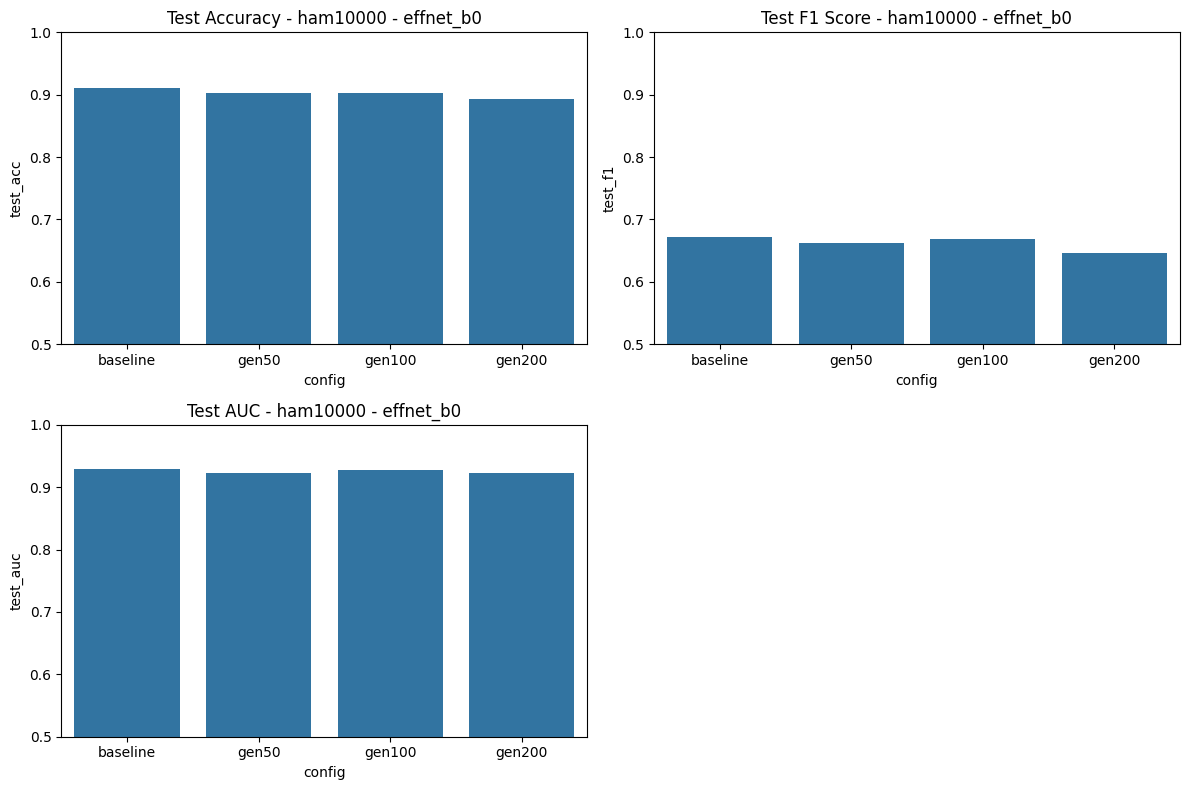

In [12]:
# Main execution
if __name__ == "__main__":
    # Install required packages
    try:
        import datasets
    except ImportError:
        print("Installing Hugging Face datasets package...")
        !pip install -q datasets
        import datasets

    # Configuration
    wandb_api_key = wandb_key  # Replace with your WandB API key or None to disable
    wandb_project = "skin-cancer-flow-matching"

    # Run all experiments
    results = run_all_experiments(wandb_api_key, wandb_project)

    print("All experiments completed!")